# Catastrophic Policy Drops during PPO

Policy gradient methods have a tendency to suffer catasrophic drops in policy performance, especially when the step size of the policy update is too large. In my experiments I frequently I saw such drops when training an agent with proximal policy optimization (PPO) in the Atari Pong environment. Pong is one of the easiest environments to learn, and it's fairly straightforward to train an agent to achieve an optimal score of +21 points in a short amount of time. When the policy collapses, it tends to quickly drop from +21 points to -21 over the span of just a few updates. Its simplicity and the suddenness of the collapse make the environment a good place to study the weaknesses and limitations of this algorithm.

The goals of this notebook are

1. to find out how the network changes during the collapse, and
2. to find out what the proximal causes of these changes are.

The hope is that we might learn something from the collapse that will enable us to write more robust policy gradient algorithms.

*Note that the model used in this notebook is not *exactly* the same as the model in this repo. It's pretty close though.*

In [1]:
# Some initial setup to load plotting and get to the correct directories.
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import sys
import os
import glob
import random

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

plt.rc('axes', labelsize='large')
plt.rc('figure', figsize=[12., 8.])

module_dir = os.path.expanduser("~/rl_jobs/ppo2-pong-1c/workspace/")
data_dir1 = os.path.expanduser("~/rl_jobs/ppo2-pong-1c/")
data_dir2 = os.path.expanduser("~/rl_jobs/ppo2-pong-1c-dense-2/")

sys.path.insert(0, module_dir)

import ppo2

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


## Behavior of the agent during training

The agent starts off with a totally random policy, and is only occasionally able to score a point against its opponent. After a relatively short time (at least by reinforcement learning standards), the agent learns to repeat these fortuitous points and score them more reliably. After about 2 million frames the agent wins its first 20 point game, and by 3 million frames it reliably wins by either 20 or 21 points.

At this point the agent is more-or-less optimal, and its performance enters a long plateau. The entropy continues to trend downwards as the agent becomes more and more sure of its actions, but the trend is slow. Then, after about 9 million frames, the agent starts to occasionally forget its good policy and score very poorly, although it quickly recovers. At 11 million frames it has a complete policy collapse. Its scores very quickly drop to -21 and its entropy drops to nearly zero.

Surprisingly, the agent is able to recover from its collapse. The recovery is much faster than its initial training, but it doesn't last. The entropy remains low, and it has another collapse a few million frames later.

Note that this cycle of collapse and recovery isn't guaranteed. This training was run with an Adam stepsize of `3e-4`, and experiments with smaller step sizes could avoid the collapse entirely. Other iterations with the same step size exhibited collapse but no recovery. It's not clear whether or not collapse would eventually occur for the smaller step size if the agent were to run for a much longer time period.

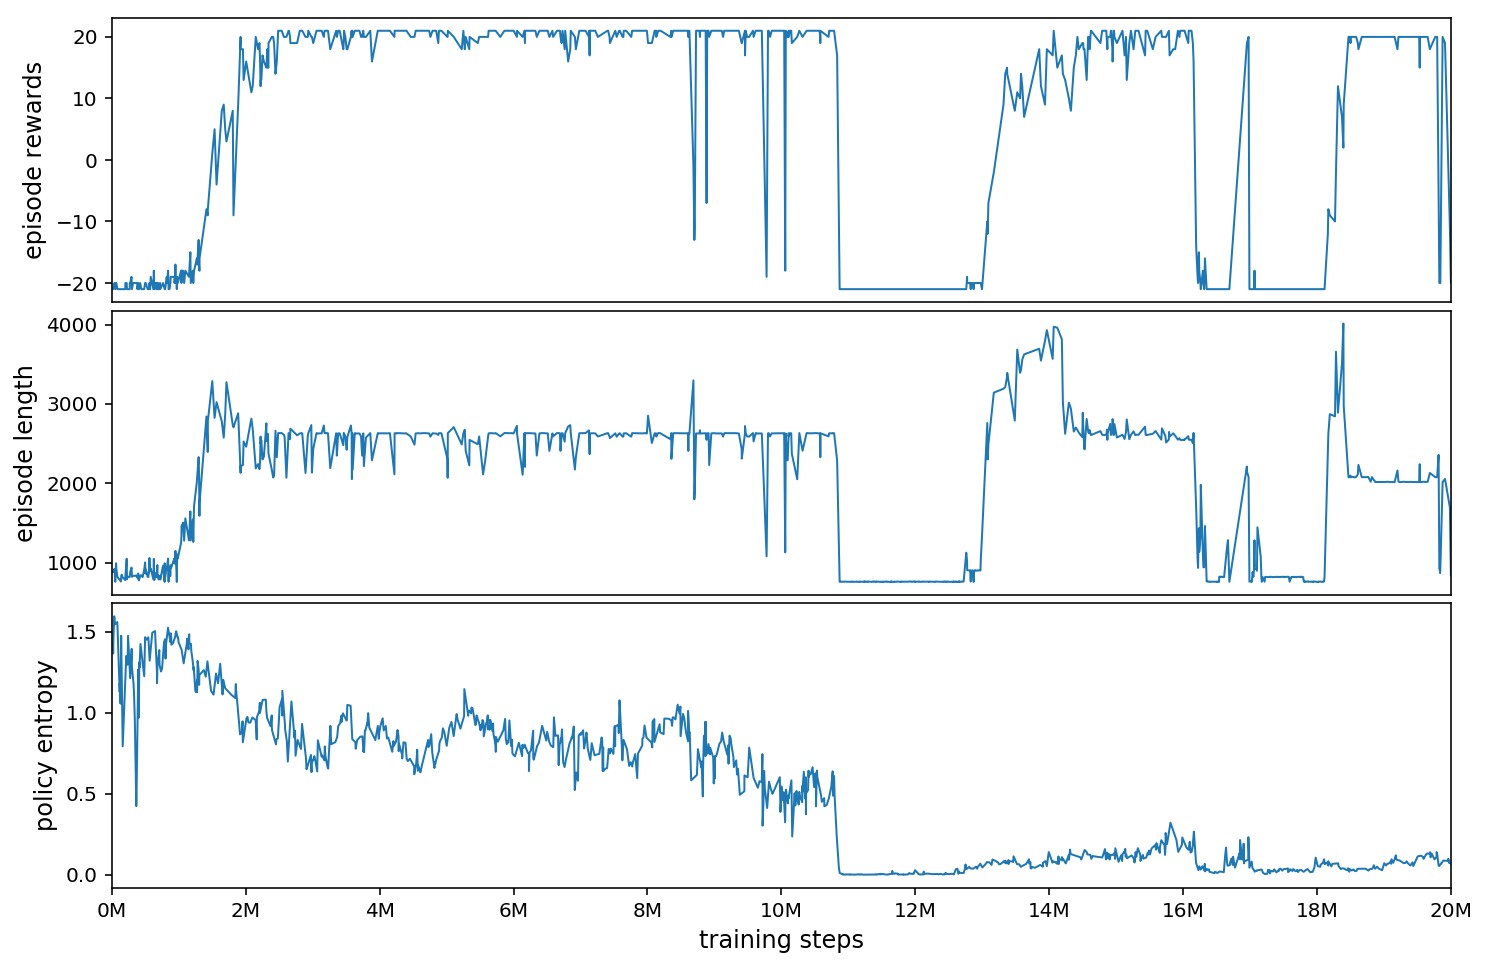

In [2]:
episode_rewards = np.loadtxt(
    data_dir1 + 'pong-1c-episode-reward.csv', delimiter=',', skiprows=1)
episode_lengths = np.loadtxt(
    data_dir1 + 'pong-1c-episode-length.csv', delimiter=',', skiprows=1)
entropy = np.loadtxt(
    data_dir1 + 'pong-1c-entropy.csv', delimiter=',', skiprows=1)
value_func = np.loadtxt(
    data_dir1 + 'pong-1c-value-func.csv', delimiter=',', skiprows=1)

plt.subplot(311)
plt.plot(episode_rewards[:,1], episode_rewards[:,2])
plt.xticks([])
plt.ylabel('episode rewards')
plt.axis(xmin=0, xmax=2e7)

plt.subplot(312)
plt.plot(episode_lengths[:,1], episode_lengths[:,2])
plt.xticks([])
plt.ylabel('episode length')
plt.axis(xmin=0, xmax=2e7)

plt.subplot(313)
plt.plot(entropy[:,1], entropy[:,2])
plt.xticks([])
plt.ylabel('policy entropy')
plt.xlabel('training steps')
plt.xticks(np.linspace(0,2e7,11), ["%iM" % i for i in range(0, 21, 2)])
plt.axis(xmin=0, xmax=2e7)
plt.subplots_adjust(hspace=0.03)

## Model changes across the collapse

In order to examine what's going on in more detail, I've rerun the training starting from a saved model just before the policy collapse, but this time saving all of the model weights much more frequently. We can load those weights and see how they change across the point of collapse.

### Output changes

First, let's generate an episode for the agent using a good policy (before collapse).

In [3]:
model_names = glob.glob(data_dir2 + '/model-*.data*')
model_names = [name.split('.')[0] for name in model_names]
model_names = [(int(name.split('-')[-1]), name) for name in model_names]
model_names.sort()  # a list of (timestep, filename) tuples

random_seed = 101
tf.set_random_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)

tf.reset_default_graph()
model = ppo2.AtariPPO('PongDeterministic-v4')
model.envs = model.envs[:1]
model.saver.restore(model.session, model_names[0][1])
batch = model.gen_batch(2000, as_np_arrays=True)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
INFO:tensorflow:Restoring parameters from /Users/maxwain/rl_jobs/ppo2-pong-1c-dense-2/model-4096
WARN: <class 'ppo2.AutoResetWrapper'> doesn't implement 'reset' method, but it implements deprecated '_reset' method.


Text(0,0.5,'reward')

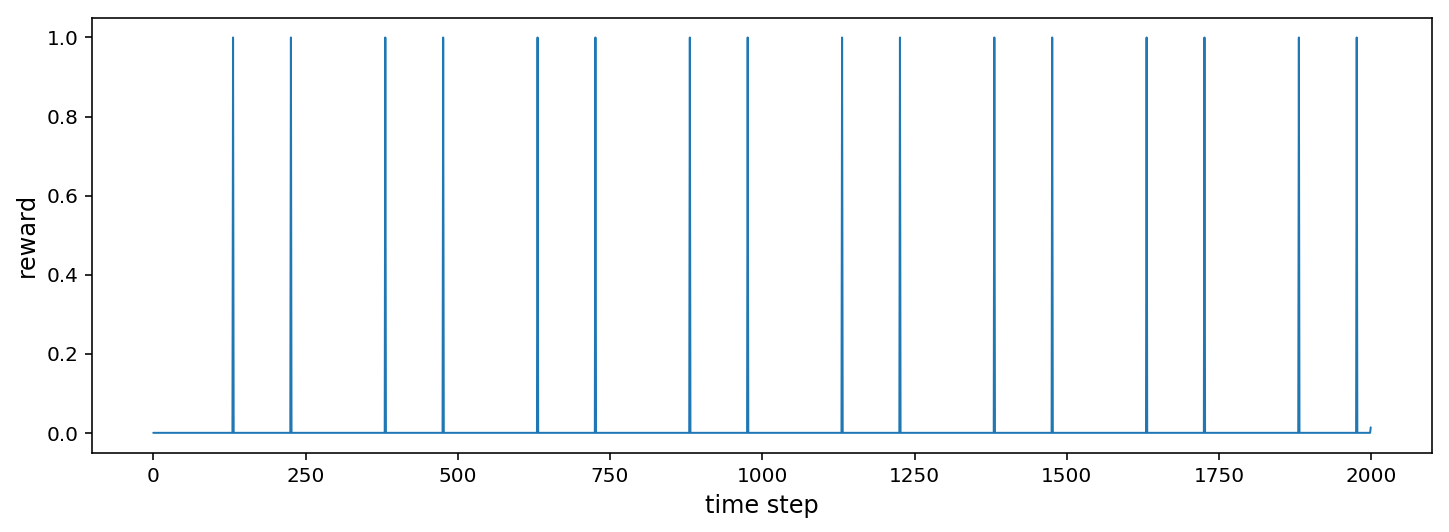

In [4]:
def recover_rewards(batch, gamma=0.99):
    r2 = np.roll(batch.r, -1)
    r2[-1] = batch.v[-1]  # not quite right, should be the state after this,
                          # but the gen_batch function doesn't keep that state
    return batch.r - gamma * r2

plt.figure(figsize=(12,4))
plt.plot(recover_rewards(batch))
plt.xlabel('time step')
plt.ylabel('reward')

As can be seen, the agent reliably scores points at regular intervals. Note that no training took place during this episode.

Now, let's load the weights for all saved models.

In [5]:
bias_vars = tf.get_collection('variables', '.*bias:0')
kernel_vars = tf.get_collection('variables', '.*kernel:0')
all_vars = bias_vars + kernel_vars


def rename_var(var):
    layer_renaming = {
        'conv2d': 'layer1',
        'conv2d_1': 'layer2',
        'conv2d_2': 'layer3',
        'dense': 'dense',
        'dense_1': 'logit',
        'dense_2': 'value',
    }
    kind_renaming = {
        'bias:0': 'bias',
        'kernel:0': 'weight'
    }
    layer, kind = var.name.split('/')
    return layer_renaming[layer] + '-' + kind_renaming[kind]


def softmax(logits):
    logits = np.asanyarray(logits)
    y = np.exp(logits - np.max(logits, axis=-1)[..., None])
    y /= np.sum(y, axis=-1)[..., None]
    return y


data = {rename_var(var):[] for var in all_vars}
data['trainstep'] = []

for t, model_name in model_names:
    model.saver.restore(model.session, model_name)
    data['trainstep'].append(t)
    vals = model.session.run(all_vars)
    for var, val in zip(all_vars, vals):
        data[rename_var(var)].append(val)
    op = model.op
    layers = model.session.run(
        [op.layer1, op.layer2, op.layer3, op.layer4, op.logits, op.v],
        {op.states: batch.s}
    )
    data.setdefault('logits', []).append(layers[-2])
    data.setdefault('v', []).append(layers[-1])

for key in data:
    data[key] = np.array(data[key])

data['policy'] = softmax(data['logits'])
data['entropy'] = -np.sum(data['policy']*np.log(data['policy']+1e-12), axis=-1)
data['trainstep'] += 10690048  # starting step of the retraining

INFO:tensorflow:Restoring parameters from /Users/maxwain/rl_jobs/ppo2-pong-1c-dense-2/model-4096
INFO:tensorflow:Restoring parameters from /Users/maxwain/rl_jobs/ppo2-pong-1c-dense-2/model-8192
INFO:tensorflow:Restoring parameters from /Users/maxwain/rl_jobs/ppo2-pong-1c-dense-2/model-12288
INFO:tensorflow:Restoring parameters from /Users/maxwain/rl_jobs/ppo2-pong-1c-dense-2/model-14336
INFO:tensorflow:Restoring parameters from /Users/maxwain/rl_jobs/ppo2-pong-1c-dense-2/model-18432
INFO:tensorflow:Restoring parameters from /Users/maxwain/rl_jobs/ppo2-pong-1c-dense-2/model-20480
INFO:tensorflow:Restoring parameters from /Users/maxwain/rl_jobs/ppo2-pong-1c-dense-2/model-22016
INFO:tensorflow:Restoring parameters from /Users/maxwain/rl_jobs/ppo2-pong-1c-dense-2/model-24064
INFO:tensorflow:Restoring parameters from /Users/maxwain/rl_jobs/ppo2-pong-1c-dense-2/model-28160
INFO:tensorflow:Restoring parameters from /Users/maxwain/rl_jobs/ppo2-pong-1c-dense-2/model-32256
INFO:tensorflow:Restor

For each set of saved weights I've calculated the model's output policy and value function for the fixed batch of states that we sampled under the good policy. We can plot the average entropy and value estimate for the different model weights on this same set of data to see that the model does indeed have a sudden collapse.

(10800000.0, 11180000.0, -2.633026522397995, 0.9964201867580413)

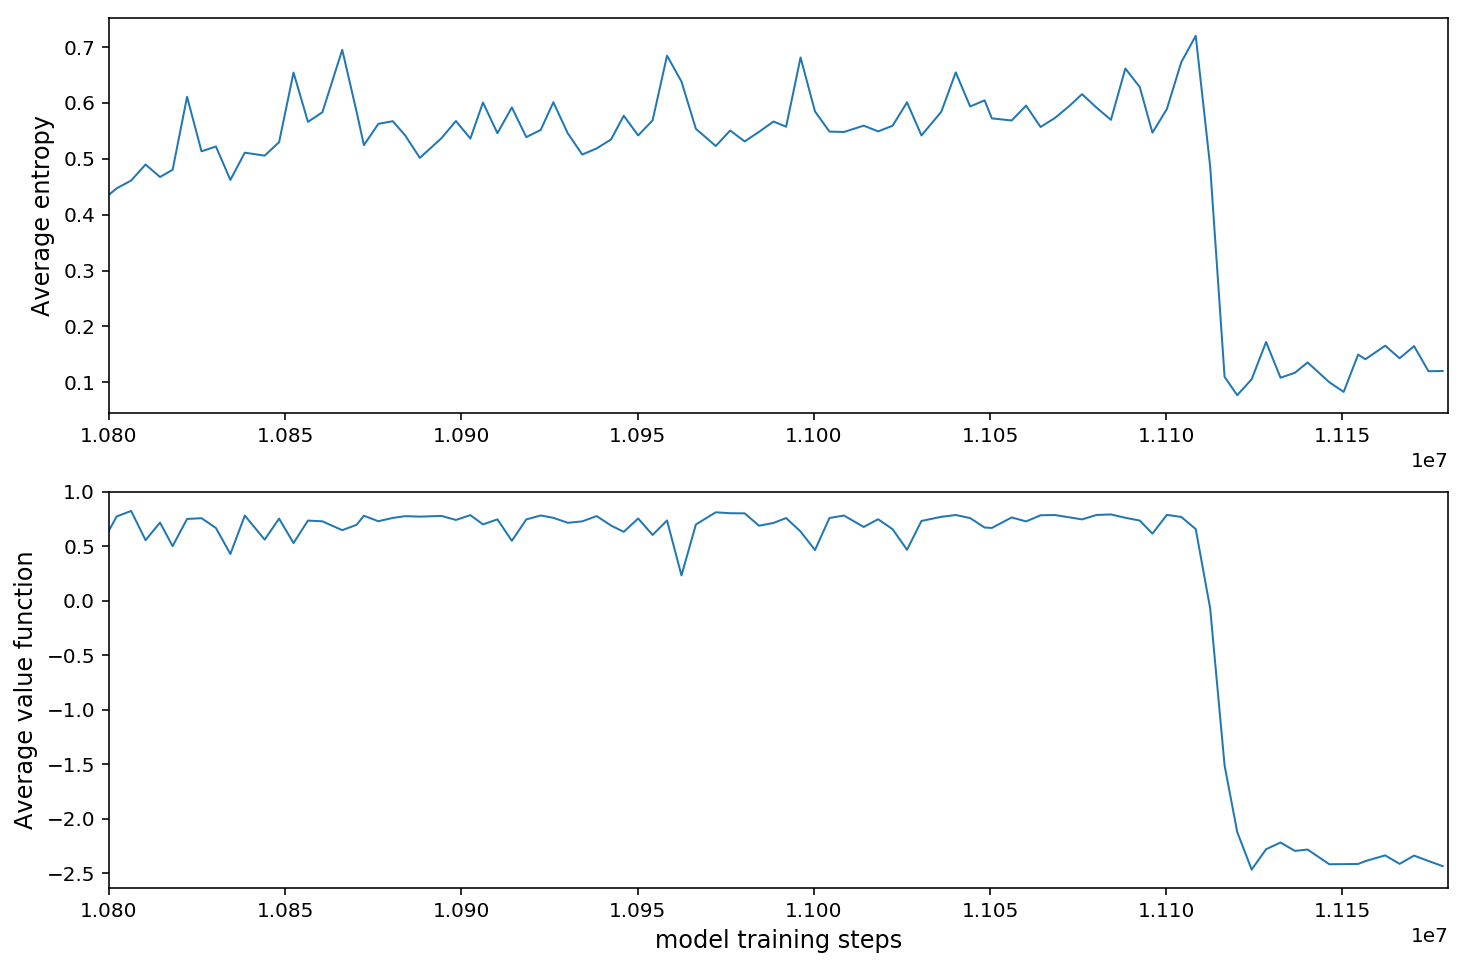

In [6]:
plt.subplot(211)
plt.plot(data['trainstep'], np.average(data['entropy'], axis=-1))
plt.ylabel('Average entropy')
plt.axis(xmin=1.08e7, xmax=1.118e7)
plt.subplot(212)
plt.plot(data['trainstep'], np.average(data['v'], axis=-1))
plt.ylabel('Average value function')
plt.xlabel('model training steps')
plt.axis(xmin=1.08e7, xmax=1.118e7)

The difference between this plot and the previous plot of entropy and rewards, other than this plot being zoomed in, is that this plot shows the average entropy and value function across a fixed set of states with only the underlying model weights changing. This shows that the collapse is not just due to small changes in policy compounding to create large changes in behavior. Instead, the policy itself changes quite dramatically (as seen in the entropy plot) over a very short period.

We can also look at how the distributions of the network's outputs change during training.

Text(0.5,0,'model training steps')

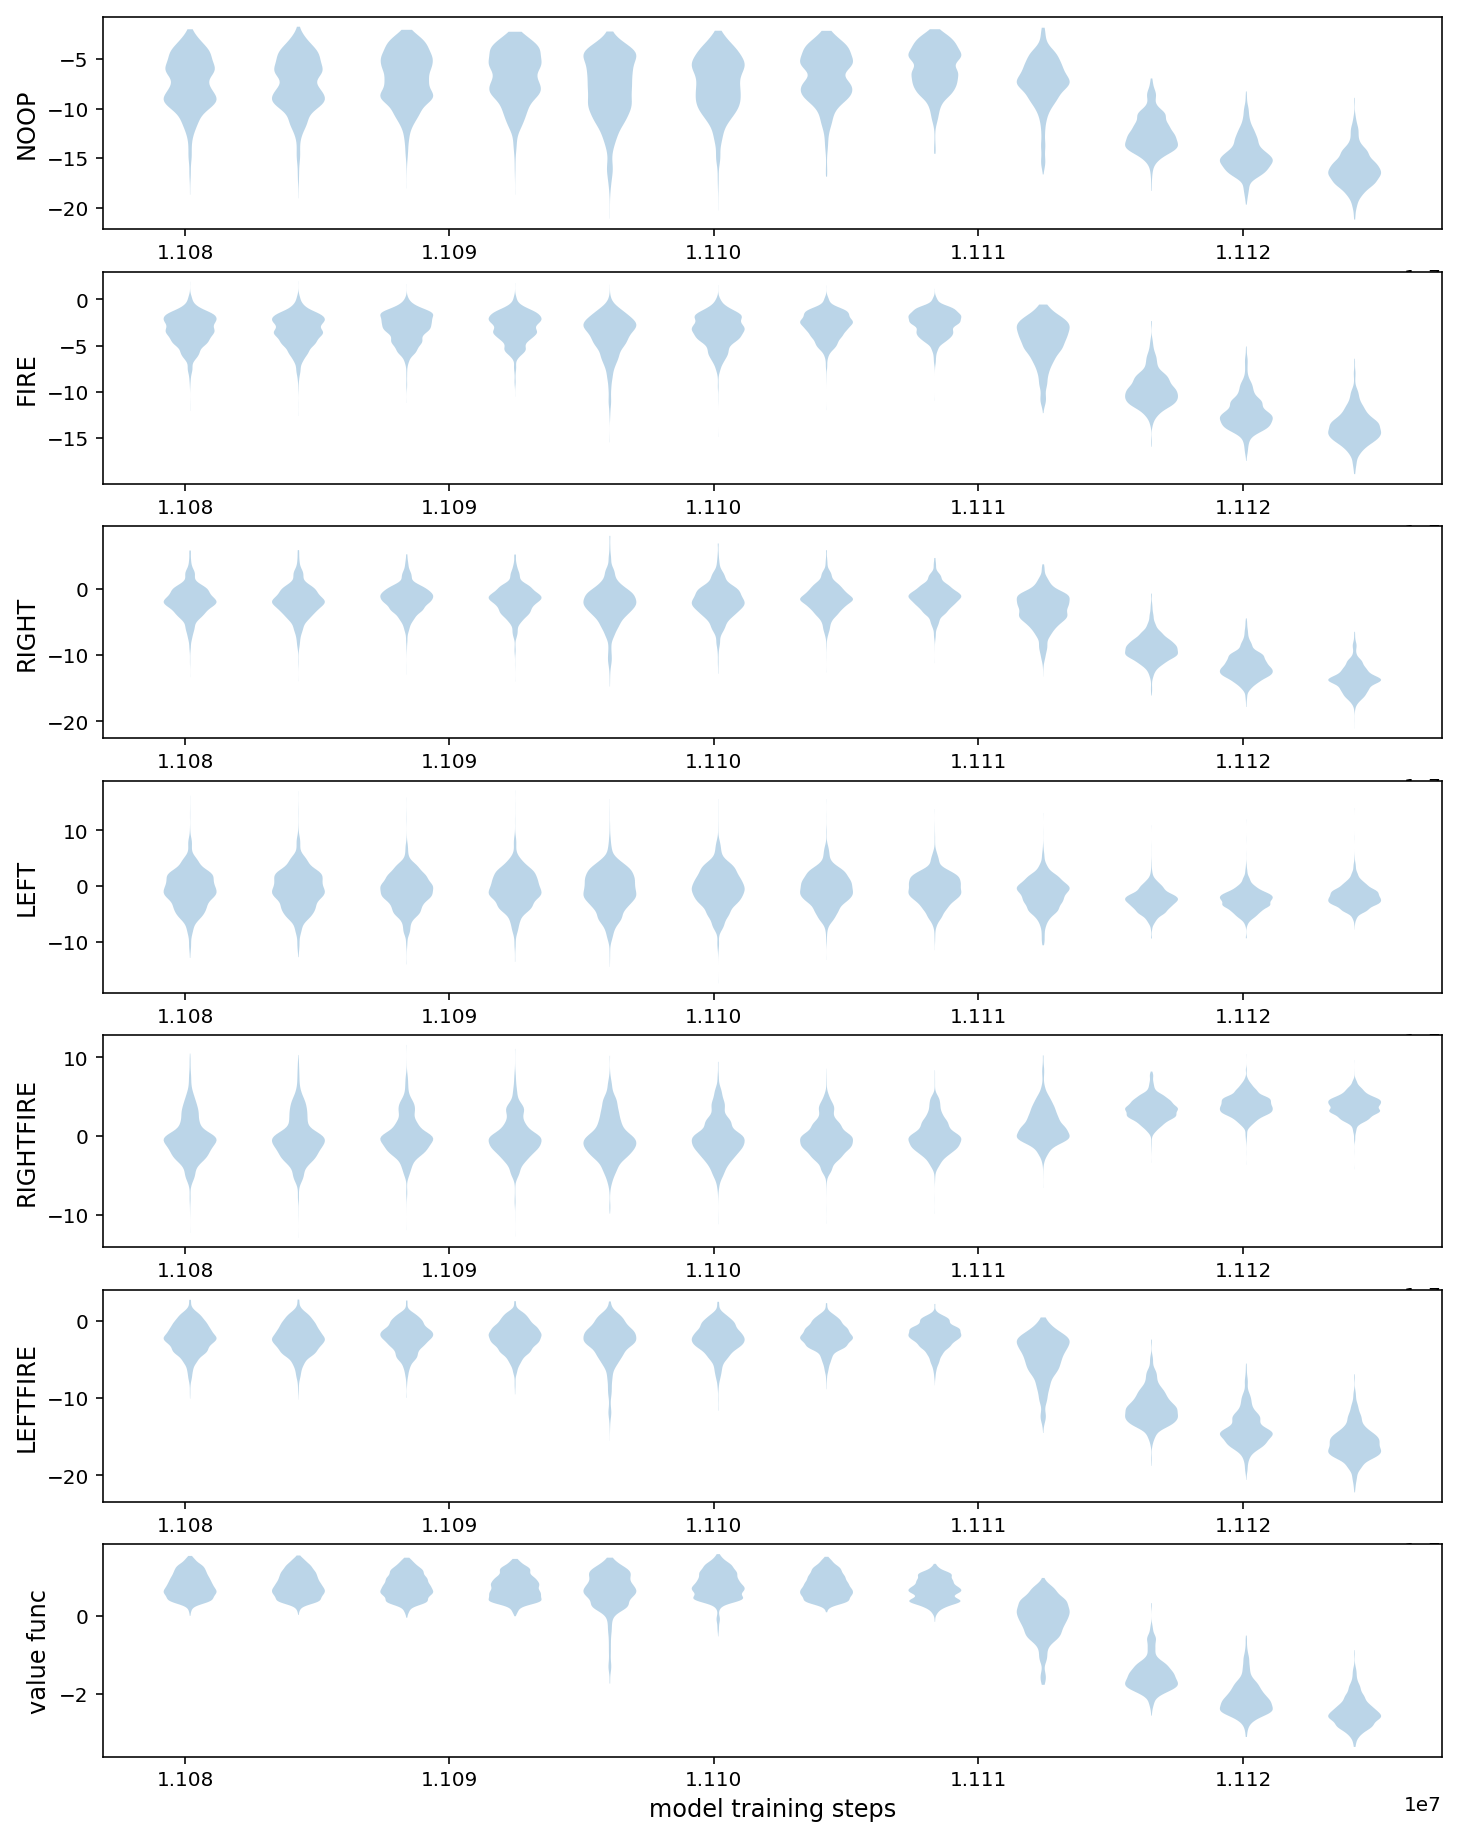

In [7]:
last_good_idx = np.argwhere(data['trainstep'] < 1.111e7)[-1, 0]
# Get the indicies in the neighborhood of the collapse:
fidx = np.arange(last_good_idx - 7, last_good_idx+5)

plt.figure(figsize=(12,16))
for i in range(6):
    plt.subplot(7,1,i+1)
    plt.violinplot(
        list(data['logits'][fidx,:,i]),
        data['trainstep'][fidx],
        widths=2000, showextrema=False)
    plt.ylabel(model.envs[0].unwrapped.get_action_meanings()[i])
plt.subplot(717)
plt.violinplot(
    list(data['v'][fidx]),
    data['trainstep'][fidx],
    widths=2000, showextrema=False)
plt.ylabel("value func")
plt.xlabel("model training steps")

At the point of collapse (around training step 11.11M) there is a large drop in the policy logits for everything except the `RIGHTFIRE` action. Note the y-scale: a two point change in a logit corresponds to nearly an order of magnitude change in the corresponding action probability, so the large changes seen here have severe effects on the agent's behavior.

We can show this somewhat more colorfully with a heatmap across all states in the episode. In the following plot, the outputs from different model weights are arranged horizontally and individual states in the episode are arranged vertically in sequential order.

(-0.5, 11.5, 1999.5, -0.5)

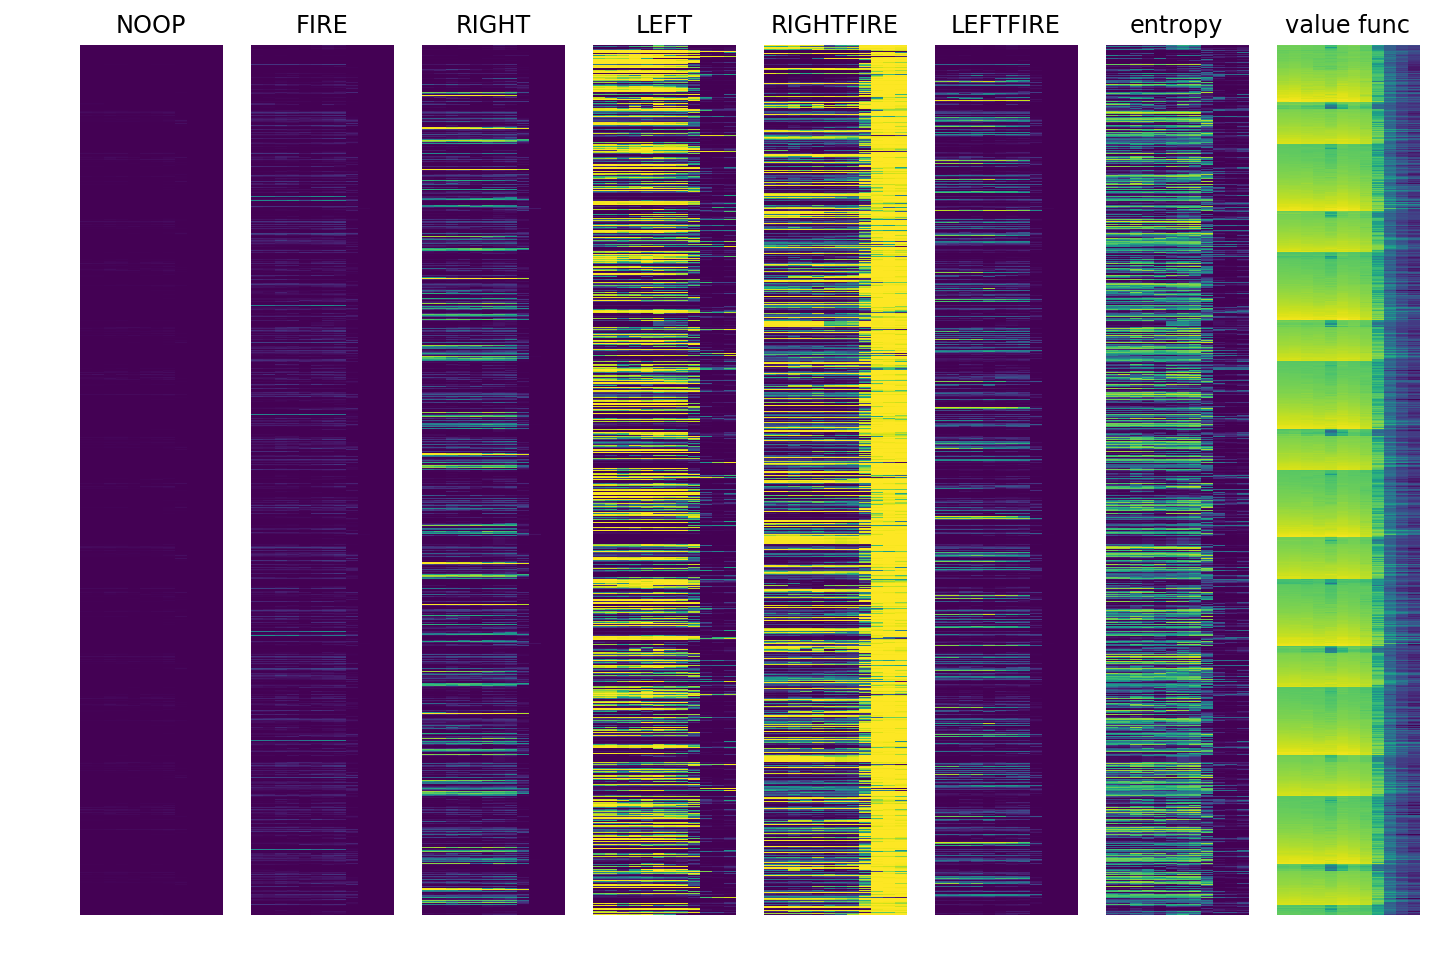

In [8]:
for i,x in enumerate(data['policy'][fidx].T):
    plt.subplot(1,8,i+1)
    plt.imshow(x, aspect='auto', vmin=0, vmax=1)
    plt.axis('off')
    plt.title(model.envs[0].unwrapped.get_action_meanings()[i])

plt.subplot(1,8,7)
plt.imshow(data['entropy'][fidx].T, aspect='auto', vmin=0, vmax=1.8)
plt.title('entropy')
plt.axis('off')
plt.subplot(1,8,8)
plt.imshow(data['v'][fidx].T, aspect='auto')
plt.title('value func')
plt.axis('off')

Before the collapse, the actions with the highest probability are either `LEFT` or `RIGHTFIRE`, but after the collapse (seen as a vertical band on the right of each image) `RIGHTFIRE` is pretty much the only action chosen. The repeating pattern seen in the value function before the collapse corresponds to repeated scores against the agent's opponent.

Note that the `FIRE` action doesn't have any real effect in Pong, so `LEFTFIRE` is basically equivalent to `LEFT` and likewise with `RIGHT`.

### Changes in model weights

Let's look at how the model weights shift in the different layers.

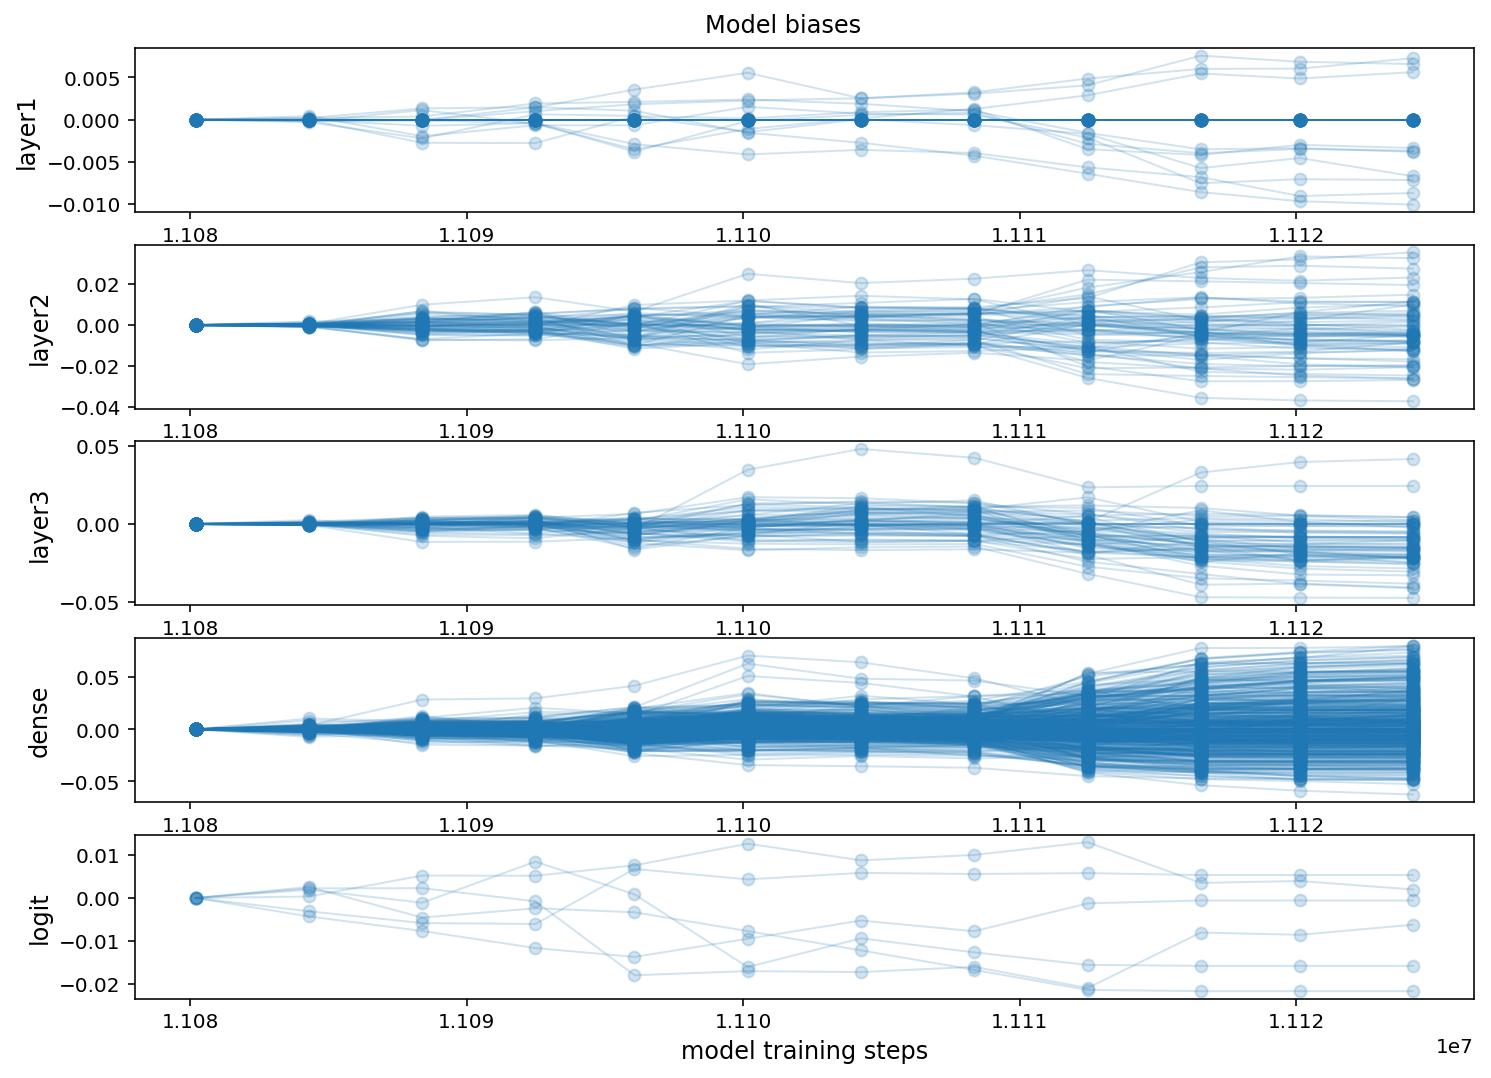

In [9]:
plt.suptitle("Model biases")
for i, name in enumerate(['layer1', 'layer2', 'layer3', 'dense', 'logit']):
    plt.subplot(5,1,i+1)
    d = data[name+'-bias'][fidx]
    plt.plot(data['trainstep'][fidx], d - d[0], '-o', color='C0', alpha=0.2)
    plt.ylabel(name)
        
plt.xlabel('model training steps')
plt.subplots_adjust(top=0.95)

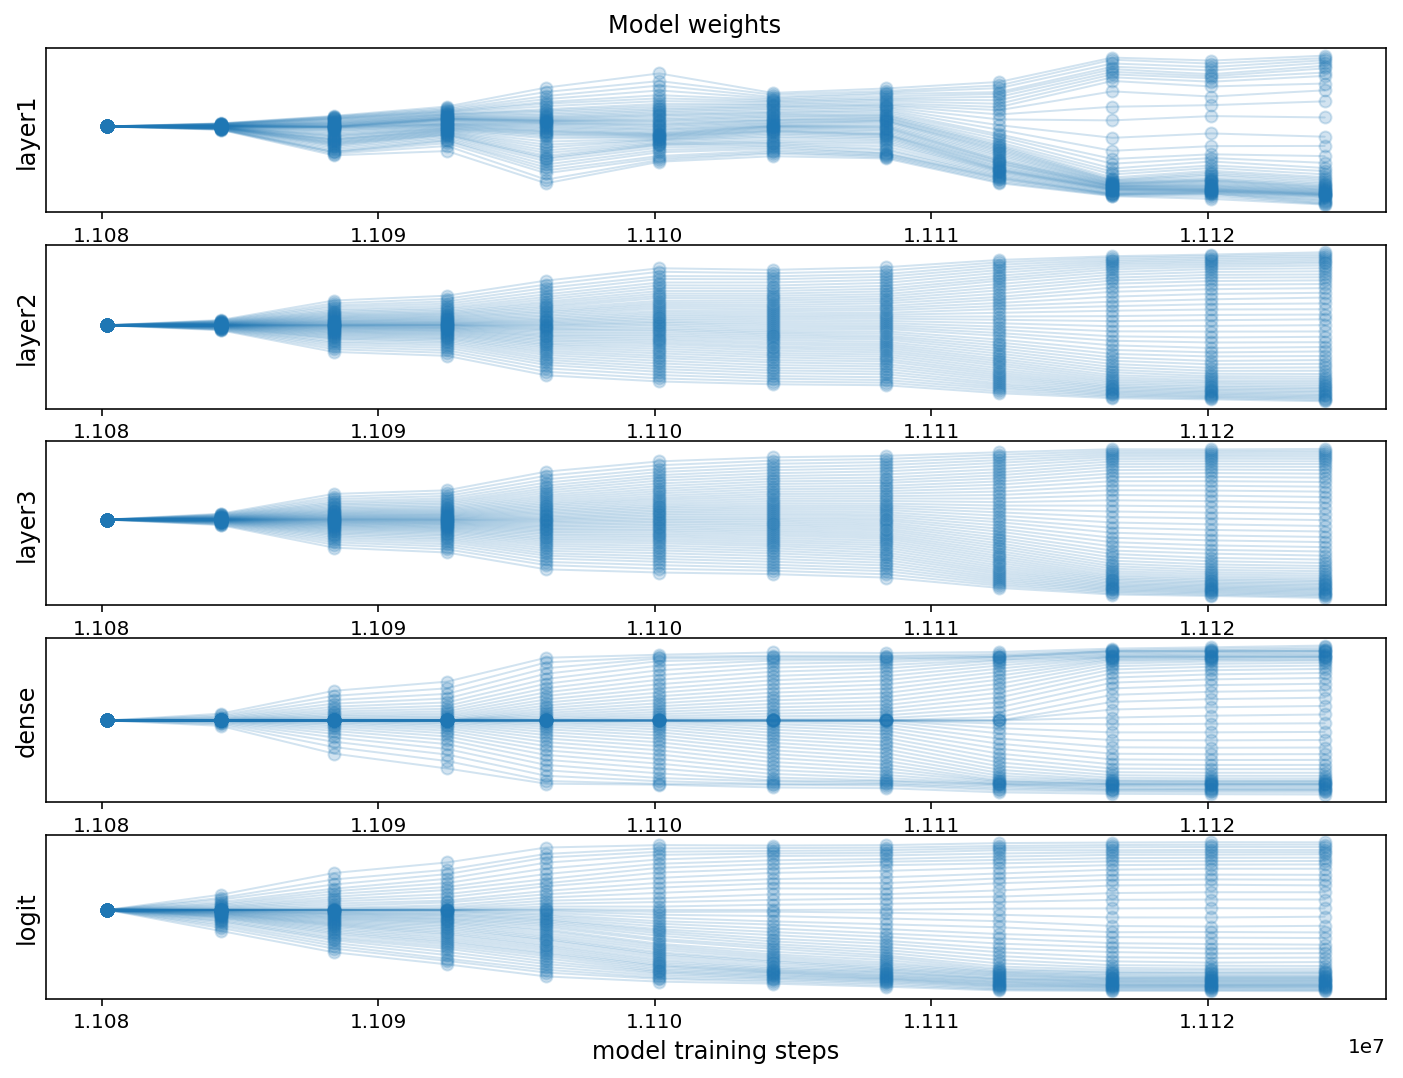

In [10]:
plt.suptitle("Model weights")
t = data['trainstep'][fidx]
for i, name in enumerate(['layer1', 'layer2', 'layer3', 'dense', 'logit']):
    plt.subplot(5,1,i+1)
    d = data[name+'-weight'][fidx]
    d = d - d[0]
    std = np.std(d, axis=0)
    d = d[:, std > 0] / std[std > 0]
    d = d.reshape(len(d), -1)
    p = np.percentile(d, np.linspace(10,90,50), axis=1).T
    plt.plot(t, p, '-o', color='C0', alpha=0.2)
    plt.yticks([])
    plt.ylabel(name)
        
plt.xlabel('model training steps')
plt.subplots_adjust(top=0.95)

The above plots show the change in model biases and model weights near the collapse (around training step 11.11M). The bias plot shows the absolute changes in individual biases, whereas the weight plot shows how the distribution of weights changes.

The changes in biases are quite small in an absolute sense, but they do show noticable shifts in layers 2 through 4 (the dense layer) at the point of collapse, with maybe a slight shift in layer 1. The weights, on the other hand, show relatively large shifts in layer 1, moderate shifts in layer 4, and very small shifts in the other layers.

It's instructive to display the filters themselves to get a sense of just how big (or small) the shifts are. In the following plots, instances of the same filter at different training steps are stacked horizontally, and different input channels are stacked vertically. 

Note that for this model, I only used two input filters instead of the customary 4. This didn't seem to make much difference for the Pong environment.

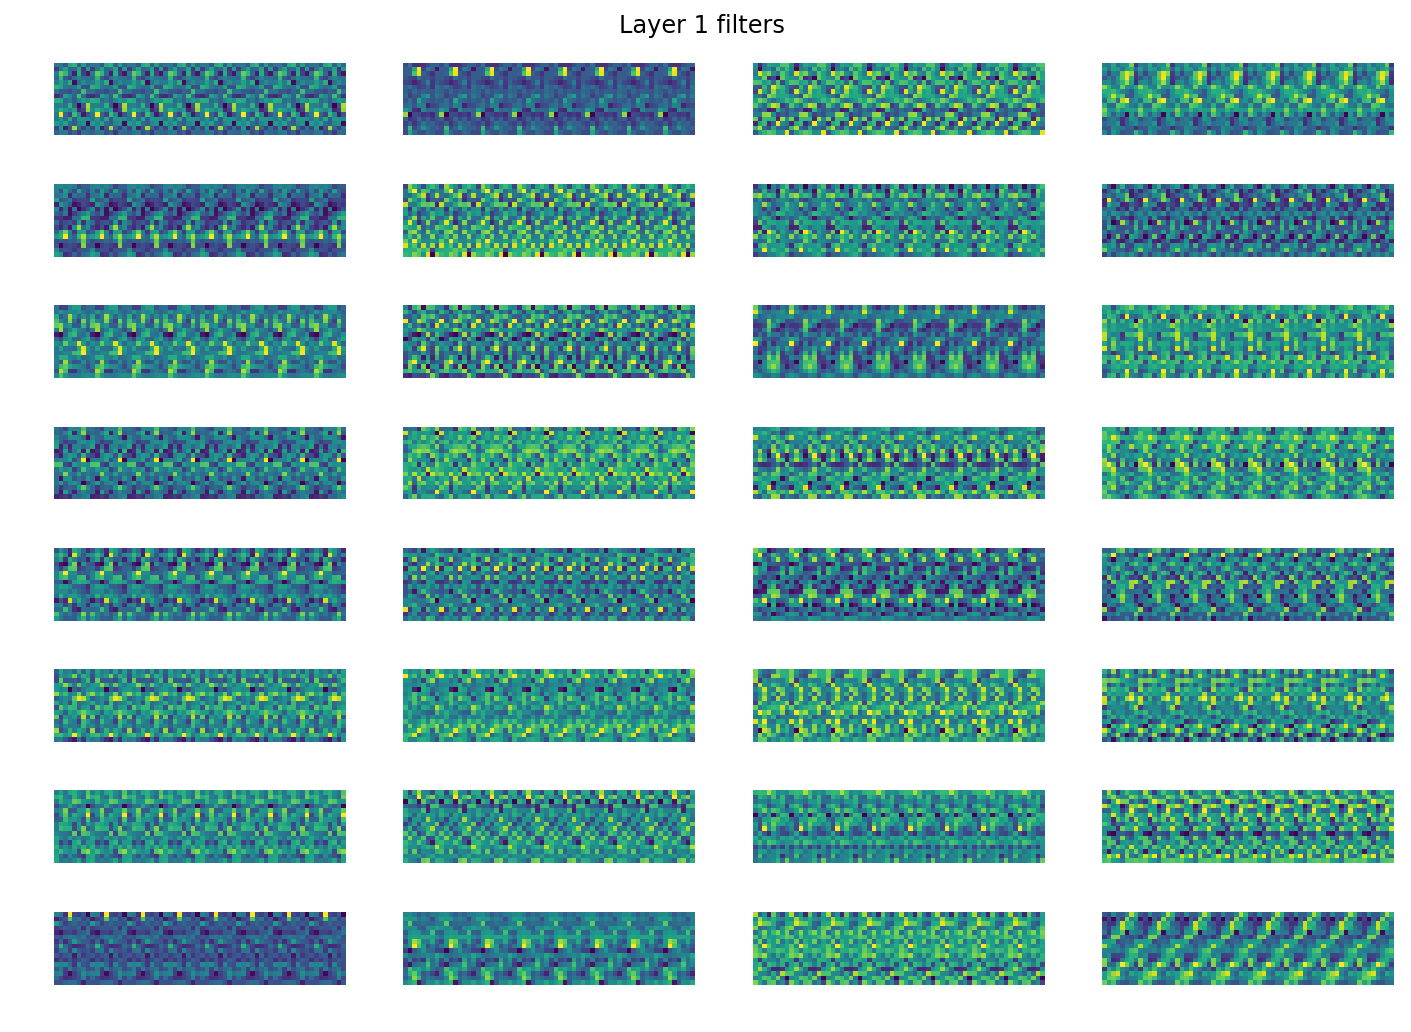

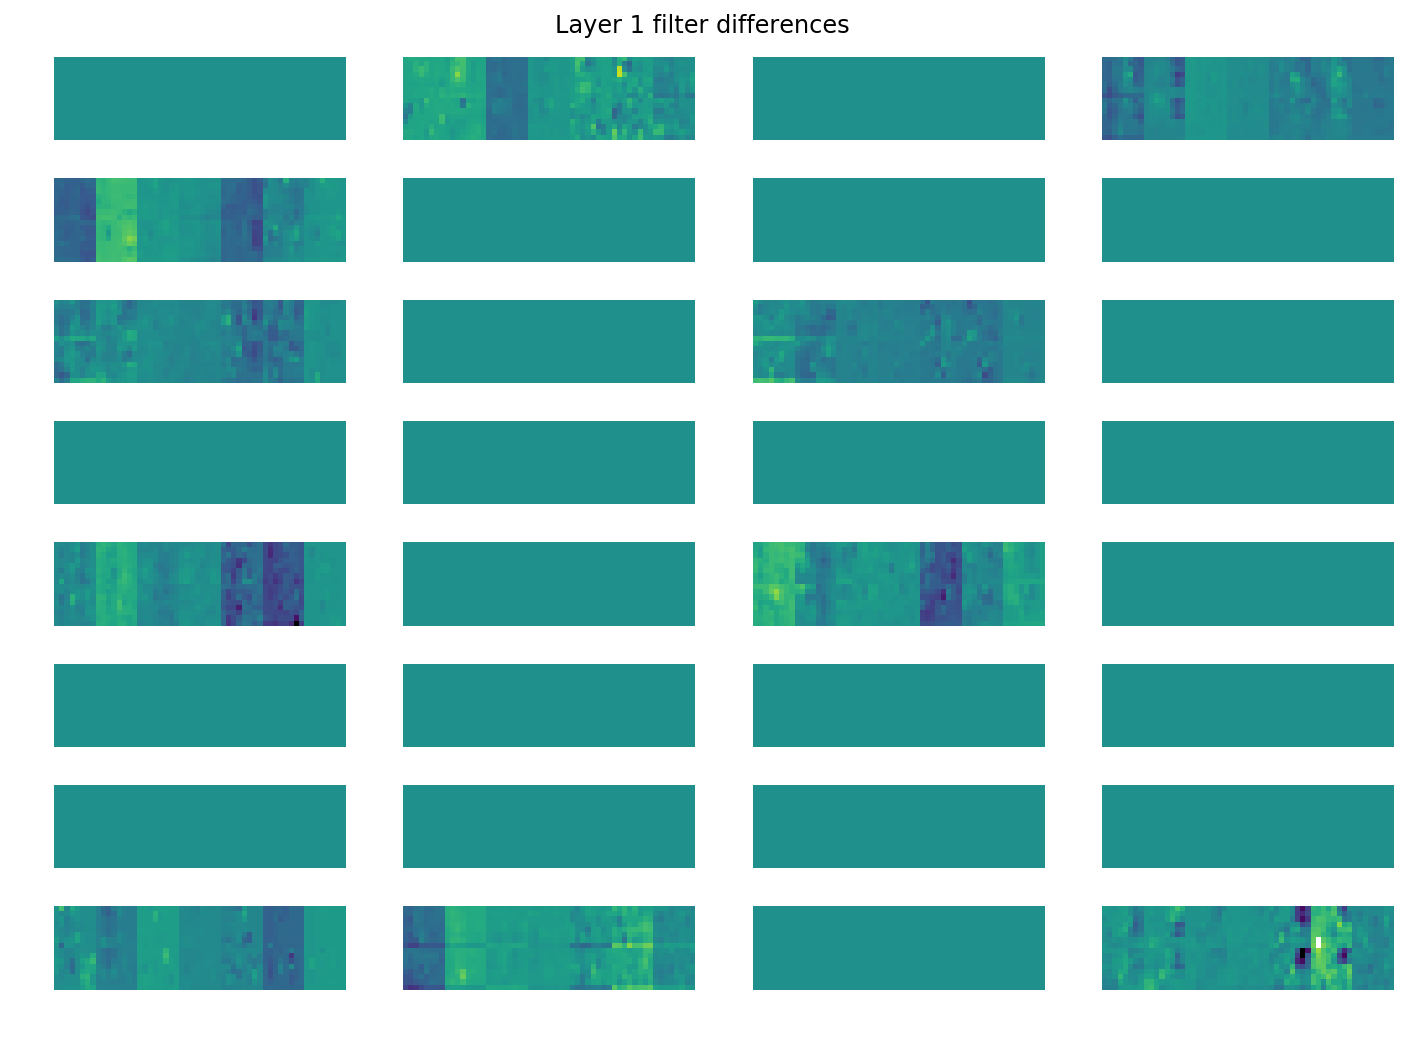

In [11]:
plt.cm.viridis.set_over('white')
plt.cm.viridis.set_under('black')
fidx2 = np.arange(last_good_idx - 4, last_good_idx + 4)


def plot_filter(x, diff=False, r=None):
    # x has shape (n,h,w,c)
    # convert to shape (c*h, n*w)
    if diff:
        x = (x[1:] - x[:-1]) / (np.max(x) - np.min(x))
    x = np.concatenate(x, axis=1)
    x = np.rollaxis(x, -1)
    x = np.concatenate(x, axis=0)
    if r is None:
        plt.imshow(x)
    else:
        plt.imshow(x, vmin=-r, vmax=r)
    

plt.figure(figsize=(12,8))
plt.suptitle('Layer 1 filters')
for i in range(32):
    plt.subplot(8,4,i+1)
    plot_filter(data['layer1-weight'][fidx2, ..., i], diff=False)
    plt.axis('off')
plt.subplots_adjust(top=0.95)
    
plt.figure(figsize=(12,8))
plt.suptitle('Layer 1 filter differences')
for i in range(32):
    plt.subplot(8,4,i+1)
    plot_filter(data['layer1-weight'][fidx2, ..., i], diff=True, r=0.01)
    plt.axis('off')
plt.subplots_adjust(top=0.95)    

The changes in the layer 1 filters are *extremely* small, around the 1% level. They are imperceptible when plotting the filters themselves (upper plot), and only become apparent when taking differences between models at adjacent training steps. Nonetheless, we will see that these tiny changes are enough to ruin the policy.

Many of the filters don't change at all. They never trigger the activation functions, and they don't contribute to the network's output. They're effectively dead.

There are similar changes in the other convolutional layers, although given how many input channels there are they become much more difficult to plot (I've tried, and it's not very informative). However, we will show that changes in individual filters in other layers do not have nearly as large an effect as changes in individual filters in the first layer.

Note that the collapse happens between the fourth and fifth time steps plotted in the differences here. The only filters that show large differences at this point are filters 4, 16, 18, and 31 (counting starting at zero).

## Interpolating across the collapse

Now that we've seen how the model changes across the collapse point, can we identify a minimal set of changes in the model's parameters that would trigger the collapse? It turns out that we can, and just a couple of filters in layer 1 are responsible for almost all of the changes.

This next set of plots shows changes in policy for individual states when we interpolate model weights across the point of policy collapse.

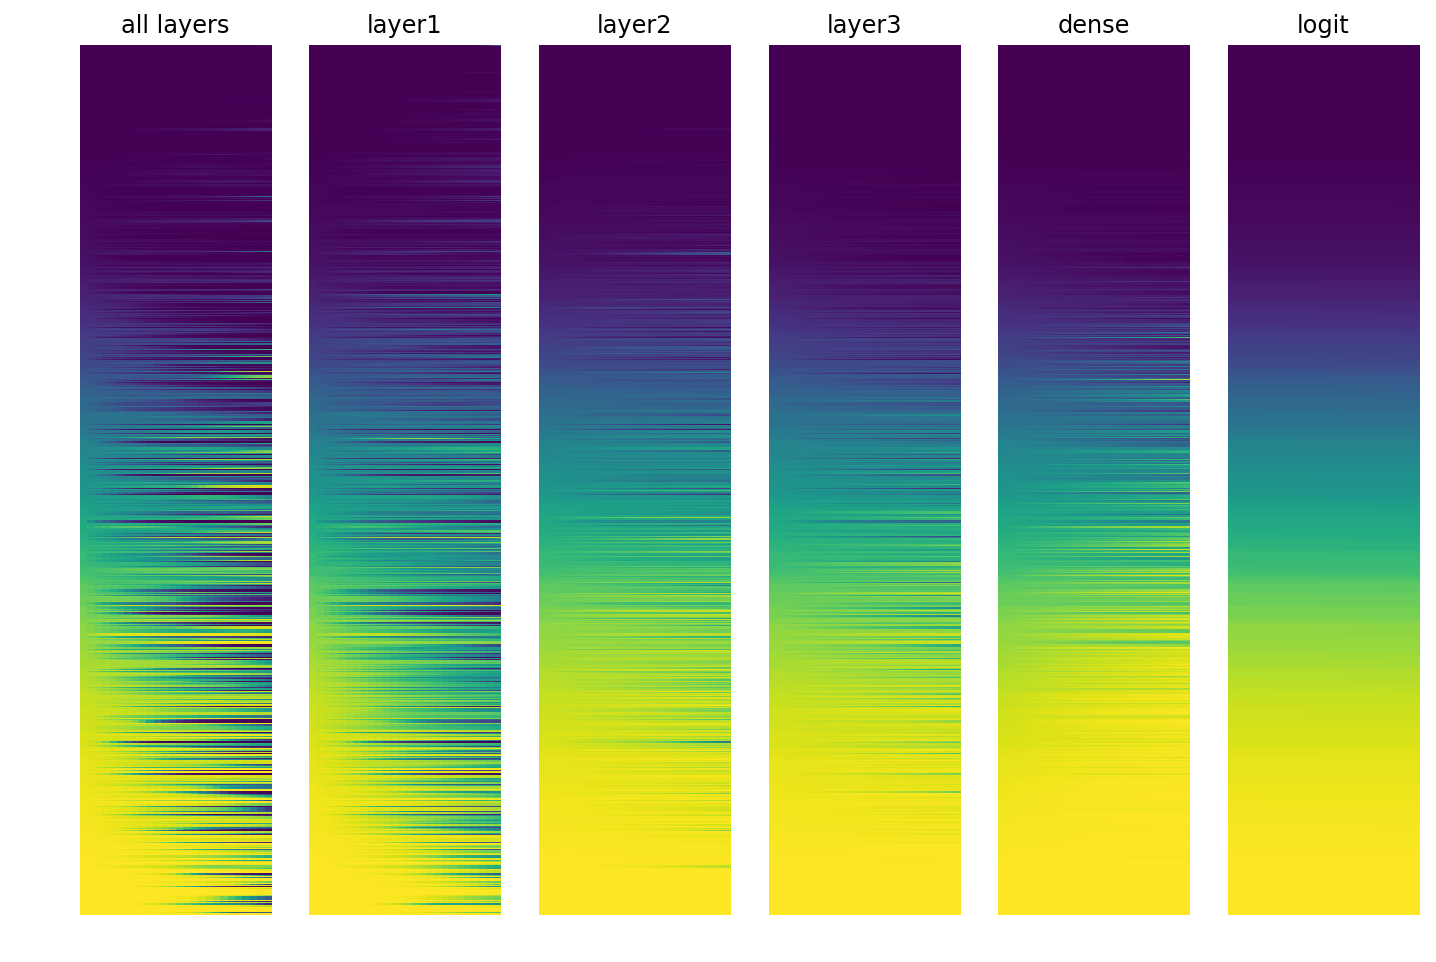

In [12]:
def interpolated_weights(x, i1, i2, include='all'):
    var_names = [(var, rename_var(var)) for var in all_vars]
    feed_dict = {}
    for var in all_vars:
        name = rename_var(var)
        d1 = data[name][i1]
        d2 = data[name][i2]
        r = x if include == 'all' or name in include else 0
        feed_dict[var] = (1-r)*d1 + r*(d2)
    return feed_dict


idx1, idx2 = last_good_idx, last_good_idx+1
for i, name in enumerate(['all layers', 'layer1', 'layer2', 'layer3', 'dense', 'logit']):
    logits = []
    for r in np.linspace(0,1,26):
        include = 'all' if name == 'all layers' else name + '-weight' + name + '-bias'
        feed_dict = interpolated_weights(r, idx1, idx2, include)
        feed_dict[model.op.states] = batch.s
        logits.append(model.session.run(model.op.logits, feed_dict))
    action_prob = softmax(logits)
    prob_left = action_prob[...,3] + action_prob[...,5]
    prob_right = action_prob[...,2] + action_prob[...,4]
    delta_prob = prob_left - prob_right
    k = np.argsort(delta_prob[0])
    plt.subplot(1,6,i+1)
    plt.imshow(delta_prob.T[k], aspect='auto', vmin=-1, vmax=1)
    plt.axis('off')
    plt.title(name)

The first column interpolates all of the weights (and biases) between models just before and after the collapse, and subsequent columns only interpolate the weights for that corresponding layer. The weights are interpolated across the horizontal dimension of each image, while different states are stacked vertically and ordered by their initial policies. The color denotes the policy for each state and each set of model weights, with yellow corresponding to a `LEFT` action and blue corresponding to a `RIGHT` action.

The first layer is the only layer which, by itself, drastically changes the agent's policy. This is interesting because the changes in the layer 1 filters were *very* small, to the point of being imperceptible when plotted.

Let's now see if we can isolate particular filters in layer 1 that have the biggest effect.

(-0.5, 11.5, 1999.5, -0.5)

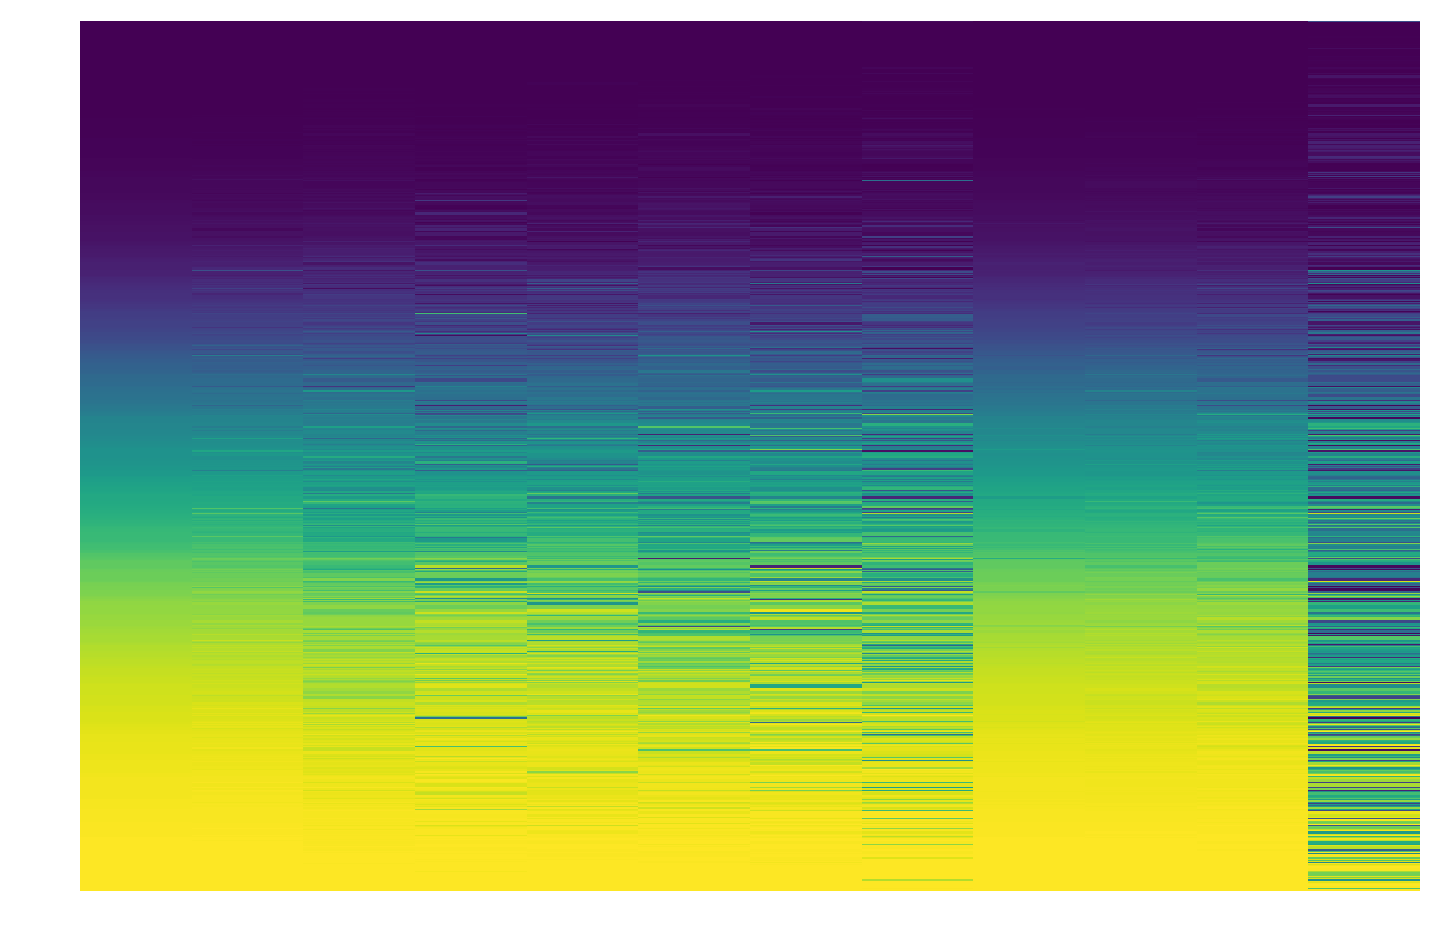

In [13]:
def interpolate_filters(x, i1, i2, layer='layer1-weight', filters=None):
    feed_dict = {}
    for var in all_vars:
        name = rename_var(var)
        if name in layer and filters is not None:
            d1 = data[name][i1].copy()
            d2 = data[name][i2]
            d1[..., filters] *= (1-x)
            d1[..., filters] += x * d2[..., filters]
            feed_dict[var] = d1
        else:
            feed_dict[var] = data[name][i1]
    return feed_dict

            
logits = []
i1, i2 = last_good_idx, last_good_idx+1
flist = [None, 1,3,4,8,10,16,18,28,29,31]
flist.append(flist[1:])
for f in flist:
    feed_dict = interpolate_filters(
        1.0, i1, i2,
        layer='layer1-weight layer1-bias',
        filters=f)
        # filters=[1,3,4,8,10,16,18,28,29,31])
    feed_dict[model.op.states] = batch.s
    logits.append(model.session.run(model.op.logits, feed_dict))

action_prob = softmax(logits)
prob_left = action_prob[...,3] + action_prob[...,5]
prob_right = action_prob[...,2] + action_prob[...,4]
delta_prob = prob_left - prob_right
idx = np.argsort(delta_prob[0])
plt.imshow(delta_prob.T[idx], aspect='auto', vmin=-1, vmax=1)
plt.axis('off')

The different columns here show the changes in policy (again, yellow is `LEFT` and blue is `RIGHT`) when only changing weights for one output channel at a time in the first layer, except that the first column has no changes, and the last column shows what happens when all of the first-layer weights change. The dead filters aren't included.

There are a few filters which by themselves seem to have large effects, although none of them individually produce the entirety of the observed collapse. However, the combined effects of filters 4, 16, and 18 seem to get us most of the way there:

(-0.5, 20.5, 1999.5, -0.5)

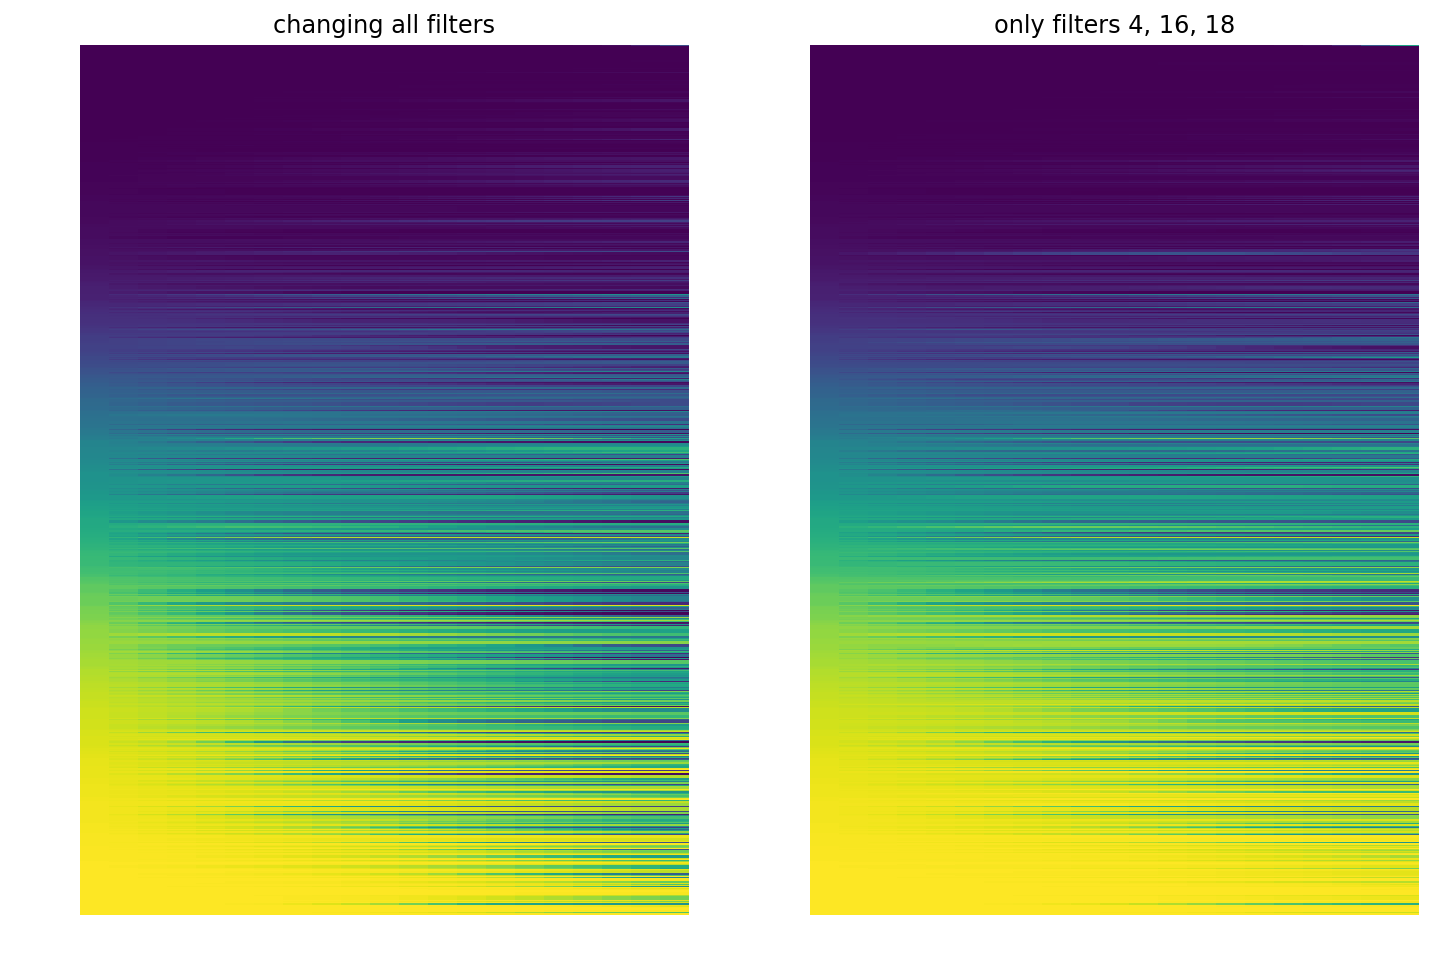

In [14]:
plt.subplot(121)
plt.title('changing all filters')
logits = []
i1, i2 = last_good_idx, last_good_idx+1
for r in np.linspace(0,1,21):
    feed_dict = interpolate_filters(
        r, i1, i2,
        layer='layer1-weight layer1-bias',
        filters=np.arange(32))
    feed_dict[model.op.states] = batch.s
    logits.append(model.session.run(model.op.logits, feed_dict))

action_prob = softmax(logits)
prob_left = action_prob[...,3] + action_prob[...,5]
prob_right = action_prob[...,2] + action_prob[...,4]
delta_prob = prob_left - prob_right
idx = np.argsort(delta_prob[0])
plt.imshow(delta_prob.T[idx], aspect='auto', vmin=-1, vmax=1)
plt.axis('off')

plt.subplot(122)
plt.title('only filters 4, 16, 18')
logits = []
i1, i2 = last_good_idx, last_good_idx+1
for r in np.linspace(0,1,21):
    feed_dict = interpolate_filters(
        r, i1, i2,
        layer='layer1-weight layer1-bias',
        filters=[4,16,18])
    feed_dict[model.op.states] = batch.s
    logits.append(model.session.run(model.op.logits, feed_dict))

action_prob = softmax(logits)
prob_left = action_prob[...,3] + action_prob[...,5]
prob_right = action_prob[...,2] + action_prob[...,4]
delta_prob = prob_left - prob_right
idx = np.argsort(delta_prob[0])
plt.imshow(delta_prob.T[idx], aspect='auto', vmin=-1, vmax=1)
plt.axis('off')

Perhaps unsurprisingly, these are the filters that show the biggest changes across the point of collapse (see the plots of the filters themselves, above).

Let's now look how the agent performs in critical scenarios.

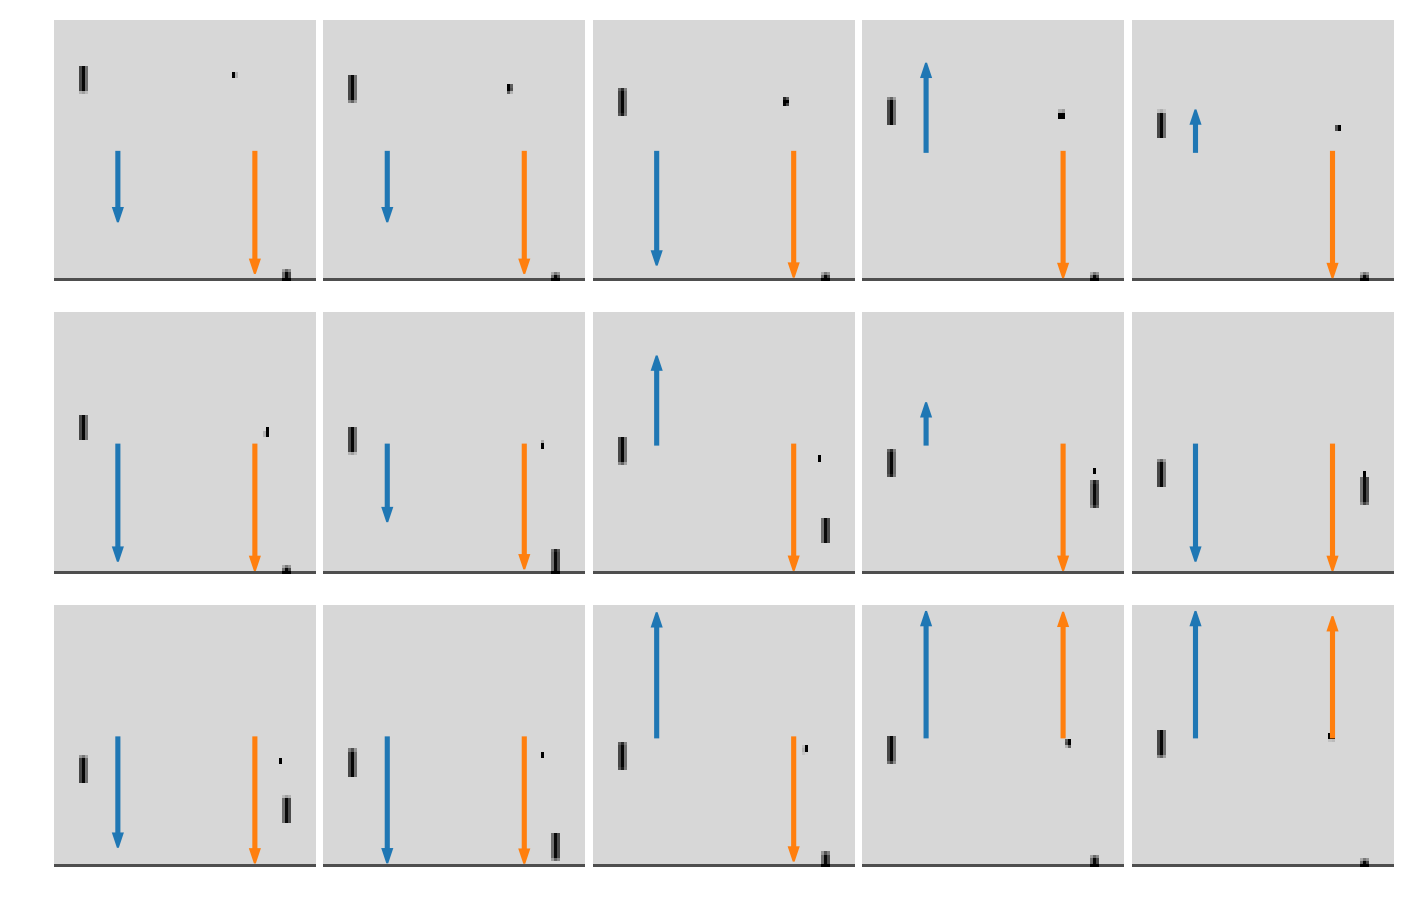

In [15]:
logits = []
i1, i2 = last_good_idx, last_good_idx+2
for r in [0, 1]:
    feed_dict = interpolate_filters(
        r, 0, i2,
        layer='layer1-weight',
        filters=[4,16,18])
    feed_dict = interpolated_weights(r, i1, i2, 'layer1-weight')
    feed_dict[model.op.states] = batch.s
    logits.append(model.session.run(model.op.logits, feed_dict))
action_prob = softmax(logits)
prob_left = action_prob[...,3] + action_prob[...,5]
prob_right = action_prob[...,2] + action_prob[...,4]
delta_prob = prob_left - prob_right


plt.figure(figsize=(12,8))
for j in range(15):
    plt.subplot(3,5,j+1)
    i = j + 50  # pick an index that's a little before the agent hits the ball
    plt.imshow(batch.s[i,...,0], cmap=plt.cm.binary, vmin=75, vmax=150)
    y1 = np.array([0, delta_prob[0,j]])
    y2 = np.array([0, delta_prob[-1,j]])
    plt.arrow(20,42,0, -delta_prob[0,j]*36, color='C0', width=1)
    plt.arrow(64,42,0, -delta_prob[-1,j]*36, color='C1', width=1)
    plt.axis('off')
plt.subplots_adjust(hspace=0.03,wspace=0.03)

This plot shows individual frames and the corresponding likelihood of choosing an up or down action for each frame. The blue (left) arrows show the probabilities for an agent just before the collapse point, and the orange (right) arrows show the probabilities when only filters 4, 16, and 18 in layer 1 are changed to match those after the collapse.

It doesn't appear that either agent would perform particularly well — the policy is obviously already a little compromised just before the collapse — but there are a few critical points where modifying the weights has clearly negative effects. The agent's paddle (on the right) starts off in the bottom corner, and just before the ball reaches its side the pre-collapse policy moves the paddle up to intercept the ball. In the same situtation, the agent with modified weights chooses to stay in the corner, and misses the ball.

At this point, we know that the collapse in the policy is due to very small changes (less than 1% difference) in just a few filters in the first convolutional layer. The collapse happens rather suddenly, and is manifested by the agent almost always choosing the same action (move to the bottom corner) with high probability, thus missing the ball. We do not, however, know *why* the filters change in this manner. Why would the policy gradient move the filters in this direction? Is it random noise, or is something else bound to move it in this direction?

## Gradients near the collapse

In order to figure out why the filters change, we need to look at the gradients of the loss functions with respect to the filters.

In [16]:
# Create a new episode using the model just before collapse.
# This model is already compromised, so we should see some point losses here
# and more variance in the states / rewards. This will give us a more accurate
# picture of what the gradients are doing in this regime.
random_seed = 101
tf.set_random_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)

tf.reset_default_graph()
model = ppo2.AtariPPO('PongDeterministic-v4')
model.envs = model.envs[:1]
model.saver.restore(model.session, model_names[last_good_idx][1])
batch2 = model.gen_batch(2000, as_np_arrays=True)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
INFO:tensorflow:Restoring parameters from /Users/maxwain/rl_jobs/ppo2-pong-1c-dense-2/model-418304


In [17]:
op = model.op
if not hasattr(op, 'grad_policy_w1'):
    # Then find the losses w.r.t. layer 1 weights.
    var_w1 = tf.get_collection('variables', 'conv2d/kernel:0')[0]
    op.grad_policy_w1 = tf.gradients(op.policy_loss, var_w1)
    op.grad_value_w1 = tf.gradients(op.value_loss, var_w1)
    # Also find the gradients of the output logits w.r.t. layer 1.
    # Only bother with actions 3 and 4 since those are the
    # only two with high probabilities.
    var_w1 = tf.get_collection('variables', 'conv2d/kernel:0')[0]
    op.grad_logits3_w1 = tf.gradients(op.logits[:,3], var_w1)
    op.grad_logits4_w1 = tf.gradients(op.logits[:,4], var_w1)
    op.grad_v_w1 = tf.gradients(op.v, var_w1)

grads = model.session.run([
    op.grad_policy_w1,
    op.grad_value_w1,
    op.grad_logits3_w1,
    op.grad_logits4_w1
], {
    op.states: batch2.s,
    op.actions: batch2.a,
    op.old_policy: batch2.pi,
    op.old_value: batch2.v,
    op.rewards: batch2.r,
    op.advantages: batch2.A,
    op.eps_clip: model.policy_clip,
})
grads = np.array(grads)

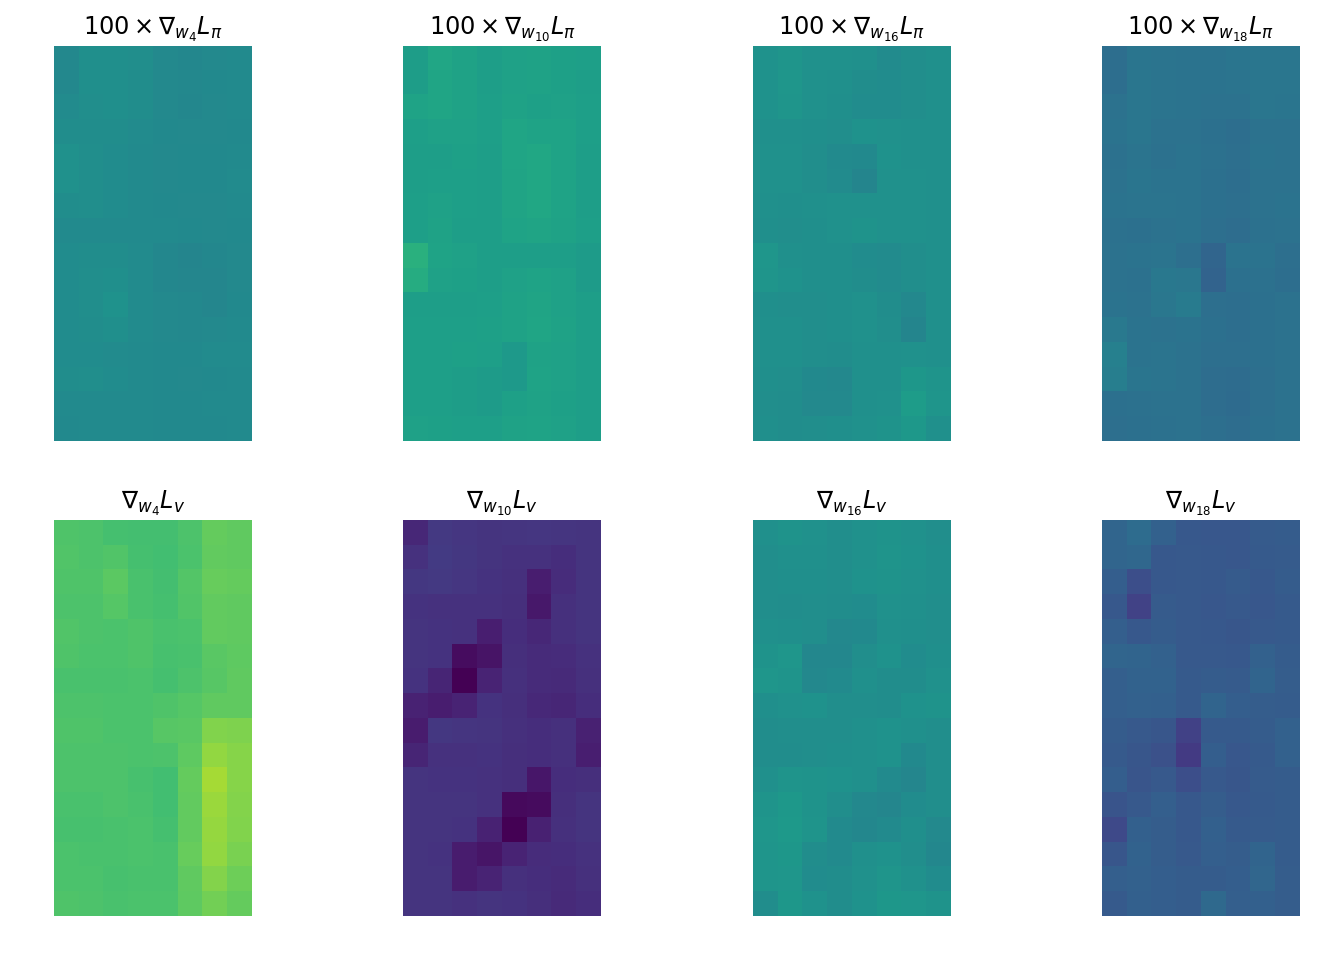

In [18]:
for i, j in enumerate([4,10,16,18]):
    plt.subplot(2,4,i+1)
    plot_filter(100 * grads[0,...,j], r=0.2)
    plt.axis('off')
    plt.title(r'$100\times\nabla_{w_{%i}} L_\pi $' % j)
    plt.subplot(2,4,i+5)
    plot_filter(grads[1,...,j], r=0.2)
    plt.axis('off')
    plt.title(r'$\nabla_{w_{%i}} L_v $' % j)

The gradients of the policy loss function with respect to the weights are very, very small. They're of order 100 times smaller than the gradients with respect to the value loss function. Therefore, changes in the model weights will be driven primarily by optimization of the value function. There's no guarantee that such changes will actually benefit the policy, so it's not terribly surprising that optimizing the value function eventually drives the policy off a cliff.

Let's look at the gradients for individual states to see if we can get a clearer sense of what's going on.

In [19]:
grads = []
for i in range(50, 66):
    grads.append(model.session.run([
        op.grad_policy_w1,
        op.grad_value_w1,
        op.grad_logits4_w1,
        op.grad_v_w1
    ], {
        op.states: batch2.s[i:i+1],
        op.actions: batch2.a[i:i+1],
        op.old_policy: batch2.pi[i:i+1],
        op.old_value: batch2.v[i:i+1],
        op.rewards: batch2.r[i:i+1],
        op.advantages: batch2.A[i:i+1],
        op.eps_clip: model.policy_clip,
    }))
grads = np.array(grads)[:,:,0]

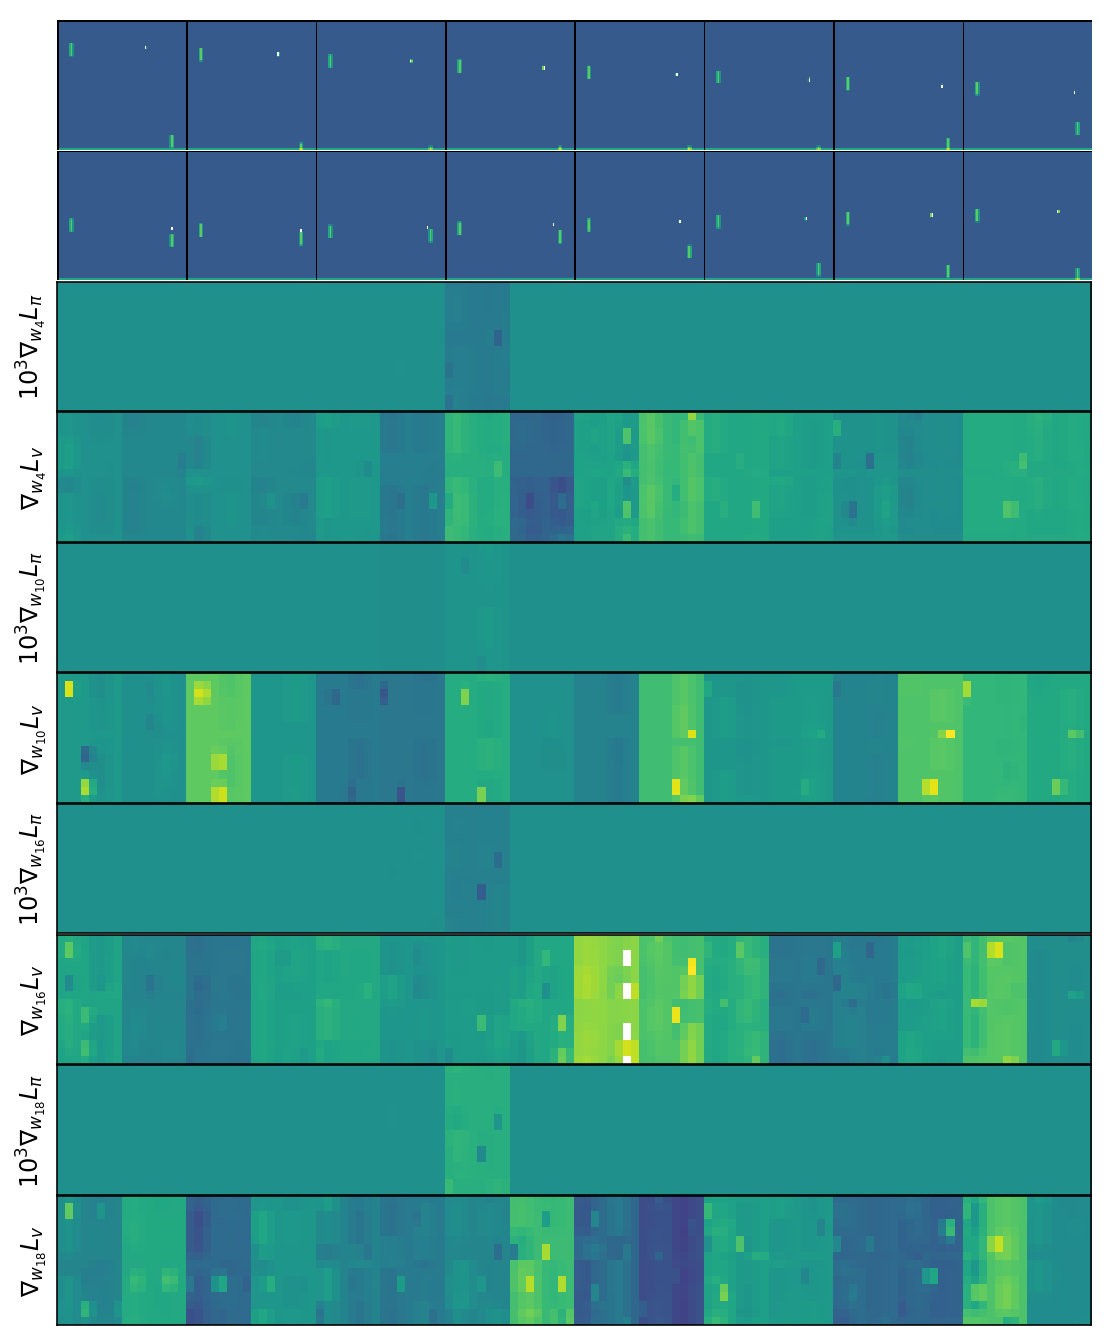

In [20]:
plt.figure(figsize=(12,12))
for i, j in enumerate([4,10,16,18]):
    plt.subplot(10,1,2*i+3)
    plot_filter(grads[:,0,...,j]*1e3, r=0.5)  # policy loss grad
    plt.xticks([])
    plt.yticks([])
    plt.ylabel(r'$10^3\nabla_{w_{%i}} L_\pi$' % j)
    plt.subplot(10,1,2*i+4)
    plot_filter(grads[:,1,...,j], r=0.5)  # value loss grad
    plt.xticks([])
    plt.yticks([])
    plt.ylabel(r'$\nabla_{w_{%i}} L_v$' % j)
states = batch2.s[50:66,...,0].copy()
states[:,:,0] = 0
states[:,0,:] = 0
plt.subplot(10,1,1)
plt.imshow(np.concatenate(states[:8], axis=1), vmin=50, vmax=180)
plt.axis('off')
plt.subplot(10,1,2)
plt.imshow(np.concatenate(states[8:], axis=1), vmin=50, vmax=180)
plt.axis('off')

plt.subplots_adjust(hspace=0.01,left=0,right=1)

Again, when looking at individual states, the policy gradient is very nearly zero. We have to multiply it by a factor of 1000 to get it to even be comparable to value gradient.

Let's instead look at gradients of the logits (specifically the `RIGHTFIRE` logit which I denote $x_R$) in the network's output.

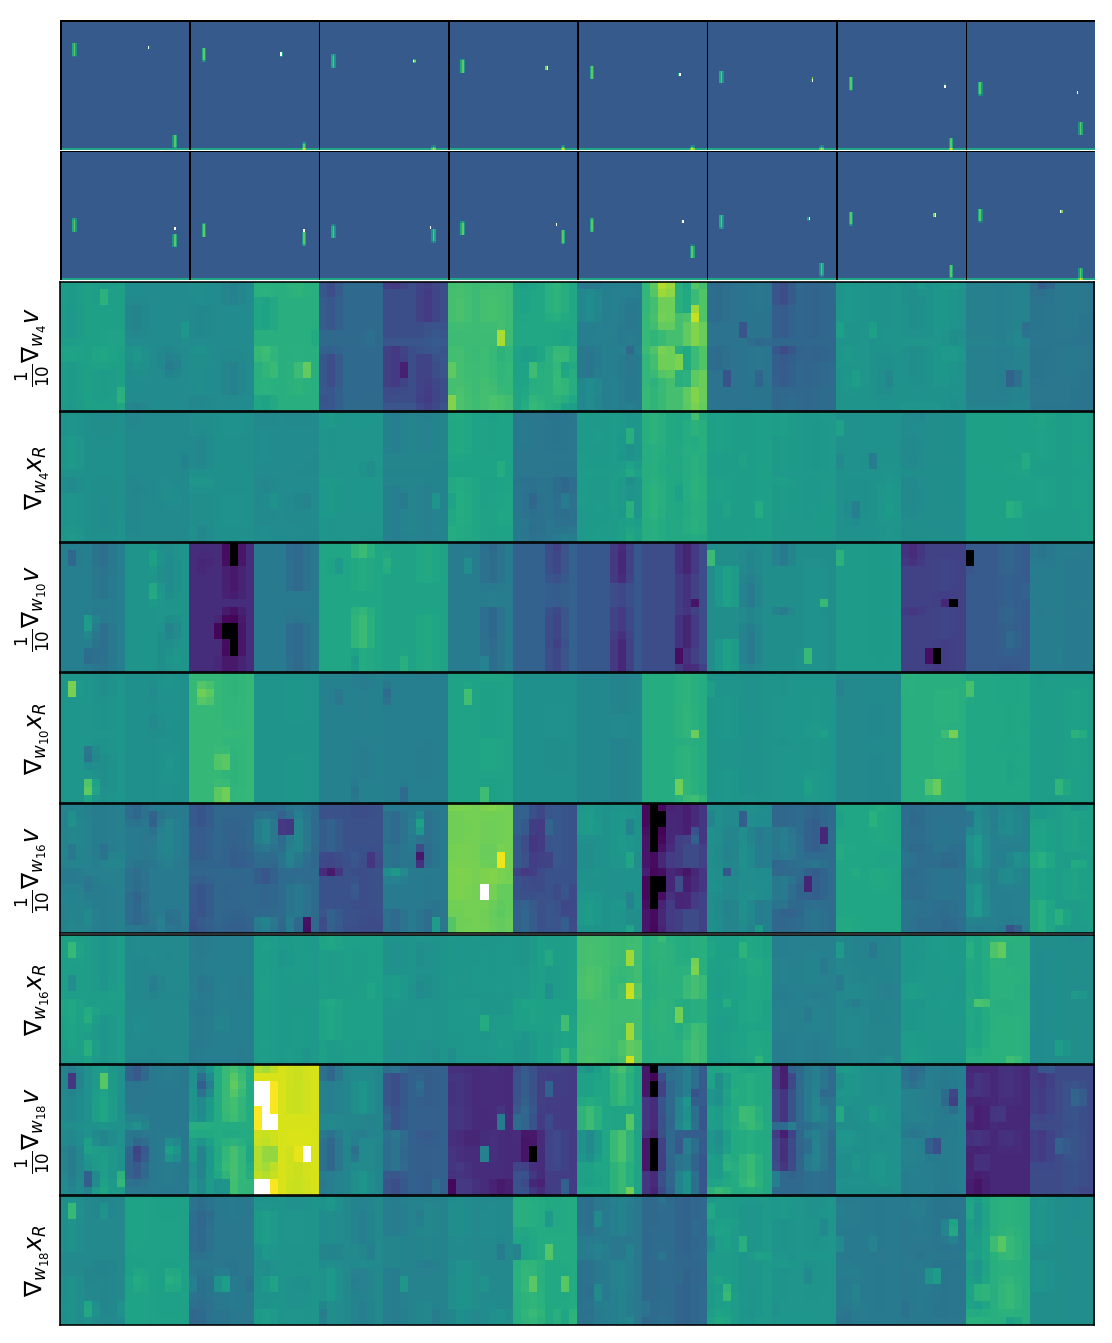

In [21]:
plt.figure(figsize=(12,12))
for i, j in enumerate([4,10,16,18]):
    plt.subplot(10,1,2*i+3)
    plot_filter(grads[:,2,...,j]*0.1, r=0.5)  # value grad
    plt.xticks([])
    plt.yticks([])
    plt.ylabel(r'$\frac{1}{10}\nabla_{w_{%i}} v$' % j)
    plt.subplot(10,1,2*i+4)
    plot_filter(grads[:,3,...,j], r=0.5)  # logit grad
    plt.xticks([])
    plt.yticks([])
    plt.ylabel(r'$\nabla_{w_{%i}} x_R$' % j)
states = batch2.s[50:66,...,0].copy()
states[:,:,0] = 0
states[:,0,:] = 0
plt.subplot(10,1,1)
plt.imshow(np.concatenate(states[:8], axis=1), vmin=50, vmax=180)
plt.axis('off')
plt.subplot(10,1,2)
plt.imshow(np.concatenate(states[8:], axis=1), vmin=50, vmax=180)
plt.axis('off')

plt.subplots_adjust(hspace=0.01,left=0,right=1)

Even though the gradient of the policy $\nabla L_\pi$ is quite small — 3 orders of magnitude below the value loss gradient $\nabla L_v$ — the gradient of the logit $\nabla x_R$ is only about a factor of 10 below than the $\nabla v$. So, if the output logits directly affect the policy, and the gradient of the logits is (relatively) large, then why is gradient of the policy so small?

Let's look at the analytic expression for the gradients, ignoring clipping. The gradients of the two components of the loss function are
$$
\frac{\partial L_v}{\partial \theta} = -A_t \frac{\partial v}{\partial \theta}; \\
\frac{\partial L_\pi}{\partial \theta} = -A_t \frac{\partial_\theta \pi(a_t | s_t)}{\pi(a_t | s_t)}.
$$
Assuming that the policy is given by a softmax over logits $x_i$, then the latter reduces to
$$
\frac{\partial L_\pi}{\partial \theta} = -A_{t} \sum_i[\delta_{a_{t}=i}-\pi(a_i|s_t)]\frac{\partial x_i}{\partial\theta}.
$$
Further assuming that $\partial_\theta x$ is of the same order as $\partial_\theta v$, then we'll always have $|\partial_\theta L_v| \gtrsim |\partial_\theta L_\theta|$. The inequality will be particularly severe when the policy is more certain such that $1 - \pi(a_t) \ll 1$. The policy really only learns when it takes an unexpected action, and as the policy gets better and better those unexpected actions will get more and more rare.

To make matters worse, $\partial_\theta x$ is *not* of the same order as $\partial_\theta v$. The latter is almost a factor of 10 bigger.

## Conclusions

The sudden collapse of the policy during the course of training seems to be caused by 3 factors:

1. The network is very sensitive to small changes in its weights, such that a percent level change in just a couple of filters can completely change the policy.
2. The gradients of the value loss function are much larger than the gradients of the policy loss function. This can either be due to very low entropy / high certainty in the policy itself, or simply having small gradients in the underlying logits. Either way, a small policy gradient means that the value function optimization will dominate the weight updates, and potentially shift the network away from good policies.
3. The optimization step size is large enough such that it does not have a chance to self-correct when the policy partially degrades. Instead, the policy fully degrades before new data is made available.

The last of these problems is easy enough to correct: we just need to make the step size smaller. This is rather unsatisfying though. It's not clear that there would be a critical threshold underneath which the problem disappears, and making the stepsize smaller obviously slows down the training. The other two problems are much more difficult to address, and will need to be the subjects of further research.
